# Implementing Decision Tree Regression Reccommender
In this workbook, we are going to create a decision tree regression model to predict the number of interaction of user for each item. It can be applied to recommender system by using top-n item with the highest predicted number of interaction. There are 3 main parts of this workbook
- Data Cleaning
- Feature Extraction
- Model Training

Before getting started, we recommend you to use Anaconda running this workbook since it already has required libraries which you can run this workbook without installing any required libraries.

## Import Libraries

Let's import required libraries for this workbook.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import tree
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

## Part 1 : Data Cleaning

In this part, we are going to look through and clean the given data including **project_unit.csv**, **project_main.csv** and **project_facility.csv** in order to make sure that we will use high quality data.

### project_unit.csv

Let's import data into a dataframe with pandas.

In [2]:
# Read 'project_unit.csv' file by using pandas

project_unit = pd.read_csv('project_unit.csv', delimiter = ';')
project_unit.head(3)

,project_id,unit_type_id,amount_bedroom,amount_bathroom,amount_car_parking,unit_starting_land_size,unit_highest_land_size,unit_functional_space_starting_size,unit_functional_space_highest_size,starting_price,highest_price,starting_price_per_area
0,4,1,3.0,3.0,2.0,NaN,NaN,154.0,NaN,NaN,NaN,NaN
1,4,1,3.0,3.0,2.0,NaN,NaN,180.0,NaN,NaN,NaN,NaN
2,4,1,3.0,3.0,2.0,NaN,NaN,189.0,NaN,NaN,NaN,NaN


There are still missing values in the data shown in the table above which we are going to get rid of. First, we want to know the percentage of missing value for each column in the dataframe.

In [3]:
# Display percentage of null values in each column

project_unit_size = len(project_unit)
null_counts = project_unit.isnull().sum()
print("Percentage of null values in each column:\n{}".format(null_counts * 100/project_unit_size))

Percentage of null values in each column:
project_id                              0.000000
unit_type_id                            0.000000
amount_bedroom                         14.470717
amount_bathroom                        14.332485
amount_car_parking                     49.028738
unit_starting_land_size                71.022190
unit_highest_land_size                 93.495817
unit_functional_space_starting_size    20.603856
unit_functional_space_highest_size     85.638414
starting_price                         85.878501
highest_price                          98.232084
starting_price_per_area                99.279738
dtype: float64


As you can see, there are many columns with high percentage of missing values. In general, the columns with more than 50% of missing value are hard to fill up so we are going to drop them.

In [4]:
# Drop the columns with missing values more than 50%

half_count = len(project_unit) / 2
project_unit = project_unit.dropna(thresh = half_count, axis = 1)
project_unit.head(10)

,project_id,unit_type_id,amount_bedroom,amount_bathroom,amount_car_parking,unit_functional_space_starting_size
0,4,1,3.0,3.0,2.0,154.00
1,4,1,3.0,3.0,2.0,180.00
2,4,1,3.0,3.0,2.0,189.00
3,29,1,3.0,2.0,2.0,114.00
4,29,1,2.0,1.0,2.0,96.00
5,228,4,3.0,2.0,1.0,140.00
6,228,4,3.0,2.0,1.0,145.00
7,156,1,NaN,NaN,NaN,NaN
8,24,1,NaN,NaN,NaN,NaN
9,73,1,3.0,3.0,2.0,150.72


There are still missing values which we are going to fill them. We think that data in same unit_type_id and same project_id should has very close number so we are going to fill missing values with mode, we considered it as a first method. However, there are still missing values which can't be calculated by using first method so we are going to fill them with mode with only same unit_type_id, we considered it as a second method.
- **Method 1** : Fill missing values with mode in same unit_type_id and same project_id 
- **Method 2** : Fill missing values with mode in same unit_type_id only

Before starting the methods above, we are going to prepare the data to be filled in **method 2**. Let's create a **mode of unit_type_id dataframe** first.

In [5]:
# Preparing fill dataframe for method 2

unit_type_mode = project_unit.drop(['project_id'], axis = 1)
unit_type_mode = unit_type_mode.groupby(['unit_type_id']).agg(lambda x: stats.mode(x)[0][0]).reset_index()
unit_type_mode.head(6)

# Note: you can use other metrics such as mean, median for this methods.

,unit_type_id,amount_bedroom,amount_bathroom,amount_car_parking,unit_functional_space_starting_size
0,1,3.0,3.0,2.0,160.0
1,2,3.0,2.0,2.0,140.0
2,3,1.0,1.0,0.0,30.0
3,4,3.0,2.0,2.0,110.0
4,5,2.0,3.0,2.0,250.0
5,6,2.0,3.0,1.0,180.0


**Mode of unit_type_id dataframe** is created but it is very hard to use, we will change it into a key-value which can be used more easily.

In [6]:
# Generate fill key-value by using unit_type_id as a main key

fill_key_values = unit_type_mode.set_index('unit_type_id').to_dict(orient = 'index')
print(fill_key_values)

{1: {'amount_bedroom': 3.0, 'amount_bathroom': 3.0, 'amount_car_parking': 2.0, 'unit_functional_space_starting_size': 160.0}, 2: {'amount_bedroom': 3.0, 'amount_bathroom': 2.0, 'amount_car_parking': 2.0, 'unit_functional_space_starting_size': 140.0}, 3: {'amount_bedroom': 1.0, 'amount_bathroom': 1.0, 'amount_car_parking': 0.0, 'unit_functional_space_starting_size': 30.0}, 4: {'amount_bedroom': 3.0, 'amount_bathroom': 2.0, 'amount_car_parking': 2.0, 'unit_functional_space_starting_size': 110.0}, 5: {'amount_bedroom': 2.0, 'amount_bathroom': 3.0, 'amount_car_parking': 2.0, 'unit_functional_space_starting_size': 250.0}, 6: {'amount_bedroom': 2.0, 'amount_bathroom': 3.0, 'amount_car_parking': 1.0, 'unit_functional_space_starting_size': 180.0}}


Since the key-value is created, we are going to do the ** method 1 **.

In [7]:
# Do the Method 1
project_unit = project_unit.groupby(['project_id','unit_type_id']).agg(lambda x: stats.mode(x)[0][0]).reset_index()
project_unit.head(10)

# Note : After this code block, the NaN values is auto filled by 0

,project_id,unit_type_id,amount_bedroom,amount_bathroom,amount_car_parking,unit_functional_space_starting_size
0,4,1,3.0,3.0,2.0,154.0
1,24,1,0.0,0.0,0.0,0.0
2,29,1,2.0,1.0,2.0,96.0
3,41,1,0.0,0.0,0.0,0.0
4,44,1,3.0,2.0,1.0,117.0
5,45,1,3.0,3.0,2.0,193.0
6,73,1,3.0,3.0,2.0,70.0
7,95,1,0.0,0.0,0.0,0.0
8,115,1,3.0,3.0,2.0,143.0
9,133,1,3.0,3.0,2.0,254.0


Then, we will do the **method 2** by getting each row of dataframe and fill the zero values ( NaN values is auto filled by 0 from previous method )

In [8]:
# Create a new dataframe
cleaned_project_unit = pd.DataFrame(columns = ['project_id','unit_type_id','amount_bedroom','amount_bathroom','amount_car_parking','unit_functional_space_starting_size'])

# loop for each row in project_unit, fill the zero value and append it to new dataframe
for i in project_unit.iterrows():
    unit_type_id = i[1]['unit_type_id']
    #check amount bedroom
    if(i[1]['amount_bedroom'] == 0):
        i[1]['amount_bedroom'] = fill_key_values[unit_type_id]['amount_bedroom']
    #check amount bathroom
    if(i[1]['amount_bathroom'] == 0):
        i[1]['amount_bathroom'] = fill_key_values[unit_type_id]['amount_bathroom']
    #check amount car parking
    if(i[1]['amount_car_parking'] == 0):
        i[1]['amount_car_parking'] = fill_key_values[unit_type_id]['amount_car_parking']
    #check unit functional space starting size
    if(i[1]['unit_functional_space_starting_size'] == 0):
        i[1]['unit_functional_space_starting_size'] = fill_key_values[unit_type_id]['unit_functional_space_starting_size']
    cleaned_project_unit = cleaned_project_unit.append(i[1],ignore_index = True)

cleaned_project_unit.head(10)

,project_id,unit_type_id,amount_bedroom,amount_bathroom,amount_car_parking,unit_functional_space_starting_size
0,4.0,1.0,3.0,3.0,2.0,154.0
1,24.0,1.0,3.0,3.0,2.0,160.0
2,29.0,1.0,2.0,1.0,2.0,96.0
3,41.0,1.0,3.0,3.0,2.0,160.0
4,44.0,1.0,3.0,2.0,1.0,117.0
5,45.0,1.0,3.0,3.0,2.0,193.0
6,73.0,1.0,3.0,3.0,2.0,70.0
7,95.0,1.0,3.0,3.0,2.0,160.0
8,115.0,1.0,3.0,3.0,2.0,143.0
9,133.0,1.0,3.0,3.0,2.0,254.0


All of missing values must be filled, we are going to recheck them.

In [9]:
# Display percentage of null values in each column
cleaned_project_unit_size = len(cleaned_project_unit)
cleaned_null_counts = cleaned_project_unit.isnull().sum()
print("Percentage of null values in each column:\n{}".format(cleaned_null_counts * 100/cleaned_project_unit_size))

Percentage of null values in each column:
project_id                             0.0
unit_type_id                           0.0
amount_bedroom                         0.0
amount_bathroom                        0.0
amount_car_parking                     0.0
unit_functional_space_starting_size    0.0
dtype: float64


The dataframe is cleaned. Let's save it to new csv file, **cleaned_project_unit.csv**, so we don't need to run our code again next time we want a cleaned data!.

In [10]:
# Save cleaned project_unit dataframe to csv
cleaned_project_unit = cleaned_project_unit.set_index('project_id')
cleaned_project_unit.to_csv('cleaned_project_unit.csv')

### project_main.csv

Now let's move to the next data, **project_main.csv**

Starting with import data into a dataframe with pandas.

In [11]:
# Read 'project_main.csv' file by using pandas

proj_main = pd.read_csv('project_main.csv', delimiter =';').set_index('project_id') 
proj_main.head(3)

,developer_id,brand_id,project_name_th,project_name_en,district_id,province_id,lat,lon,project_land_size_rai,project_land_size_ngan,project_land_size_wa,total_unit,percent_car_parking,starting_price,highest_price,project_status,created_at
project_id,,,,,,,,,,,,,,,,,
44,140786,0.0,พาร์ควิลล์ 3,Parkville 3,1046.0,10,13.891719,100.722099,54,0,0,NaN,NaN,3500000.0,3862000.0,A,2011-01-14T18:40:12.117+0700
24,1032,0.0,สัมมากร นิมิตใหม่,Sammakorn Nimitmai,1046.0,10,13.876590,100.731927,154,3,89,NaN,NaN,4590000.0,NaN,U,2011-02-24T21:43:59.297+0700
161,11066,0.0,บ้านพฤกษา 28/2 นิคมบางปู (เทพารักษ์-สุวรรณภูมิ),NaN,1101.0,11,13.543841,100.656302,0,0,0,NaN,NaN,912400.0,1300480.0,U,2009-07-20T07:00:00.000+0700


Column with to many **unique values** (such as ID) can cause overfitting so we need to narrow down those column.
First, let's print out percentage of unique values in each column to find out which column we need to drop.

In [12]:
# Display percentage of unique values in each column

proj_main_size = len(proj_main)
num_unique = proj_main.nunique()
print("Percentage of unique values in each column:\n{}".format(num_unique * 100/proj_main_size))

Percentage of unique values in each column:
developer_id              41.327384
brand_id                  33.203198
project_name_th           99.776910
project_name_en           97.062651
district_id                3.773936
province_id                1.041086
lat                       98.661461
lon                       98.717234
project_land_size_rai      2.993121
project_land_size_ngan     0.501952
project_land_size_wa       3.364938
total_unit                15.950920
percent_car_parking        1.840491
starting_price            13.552705
highest_price              8.179959
project_status             0.074363
created_at                94.645845
dtype: float64


As you can see, some of them contain too many unique values. In this case, column with more than 20% unique values should be dropped.

In [13]:
#### TODO 1 ####

# Drop unique columns (more than 30%)
proj_main = 

################

There are also missing values in this data so we are going to get rid of them too. 

In [14]:
# Display number of null values in each column

proj_main_size = len(proj_main)
null_counts = proj_main.isnull().sum()
print("Percentage of null values in each column:\n{}".format(null_counts * 100/proj_main_size))

Percentage of null values in each column:
district_id                0.223090
province_id                0.000000
project_land_size_rai      0.000000
project_land_size_ngan     0.000000
project_land_size_wa       0.000000
total_unit                34.523146
percent_car_parking       89.496189
starting_price             1.710355
highest_price             78.174382
project_status             0.000000
dtype: float64


In [15]:
#### TODO 2 ####

# Drop any column with more than 30% missing values
proj_main = 

# Hint : DataFrame.dropna()

##############

In [16]:
proj_main.head()

,district_id,province_id,project_land_size_rai,project_land_size_ngan,project_land_size_wa,starting_price,project_status
project_id,,,,,,,
44,1046.0,10,54,0,0,3500000.0,A
24,1046.0,10,154,3,89,4590000.0,U
161,1101.0,11,0,0,0,912400.0,U
73,1301.0,13,112,0,17,3800000.0,A
219,1103.0,11,51,2,29,5000000.0,A


Even though we have dropped columns with a lot of NaN, there are still null cells in our dataframe. Dropping rows that contain NaN columns is better than dropping columns now since there are not many rows with NaN.

In [17]:
#### TODO 3 ####

# Drop row with NaN columns
proj_main = 

# Hint : DataFrame.dropna()

################

proj_main_size = len(proj_main)
null_counts = proj_main.isnull().sum()
print("Percentage of null values in each column:\n{}".format(null_counts * 100/proj_main_size))

# All of them must be 0

Percentage of null values in each column:
district_id               0.0
province_id               0.0
project_land_size_rai     0.0
project_land_size_ngan    0.0
project_land_size_wa      0.0
starting_price            0.0
project_status            0.0
dtype: float64


There are 3 columns describing projects' land size which are **project_land_size_rai**, **project_land_size_ngan**, and **project_land_size_wa**.

We are going to **sum them into one column** in the smallest unit which is wa.

In [18]:
# Sum project land size to have only one column, wa.

proj_main['landSize'] = proj_main['project_land_size_rai']*400 + proj_main['project_land_size_ngan']*100 + proj_main['project_land_size_wa']
proj_main = proj_main.drop(['project_land_size_rai','project_land_size_ngan','project_land_size_wa'],axis=1)

In [19]:
proj_main.head(3)

,district_id,province_id,starting_price,project_status,landSize
project_id,,,,,
44,1046.0,10,3500000.0,A,21600
24,1046.0,10,4590000.0,U,61989
161,1101.0,11,912400.0,U,0


Next, we are going to **divide starting price into 4 categories**, 0 (lowest), 1 (low), 2 (medium), and 3 (high) by using log of starting price. Unfortunately, there are skewness in our data so we should take log to the starting price column to plot graph that easier to analyze.

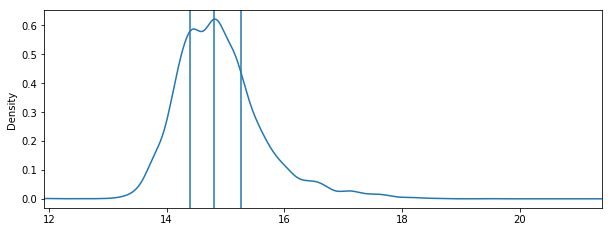

In [20]:
i = 'Log_starting_price'

# Log Transform
proj_main[i] = np.log(proj_main['starting_price'])

q75, q50, q25 = np.percentile(proj_main.Log_starting_price.dropna(), [75 ,50, 25])

min = q25
mid = q50
max = q75

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(proj_main[i].min(), proj_main[i].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=mid)
plt.axvline(x=max)

ax = proj_main[i].plot(kind='kde')

proj_main['priceRange'] = 0

proj_main.loc[proj_main[i] < min, 'starting_price_range'] = 0
proj_main.loc[((proj_main[i] > min) & (proj_main[i] < mid)), 'starting_price_range'] = 1
proj_main.loc[((proj_main[i] > mid) & (proj_main[i] < max)), 'starting_price_range'] = 2
proj_main.loc[proj_main[i] > max, 'starting_price_range'] = 3

proj_main = proj_main.drop(i, axis = 1)

Let's look into our dataframe now.

In [21]:
proj_main.head(3)

,district_id,province_id,starting_price,project_status,landSize,priceRange,starting_price_range
project_id,,,,,,,
44,1046.0,10,3500000.0,A,21600,0,2.0
24,1046.0,10,4590000.0,U,61989,0,3.0
161,1101.0,11,912400.0,U,0,0,0.0


There is **another csv file contains facility list** for each project, we need to include that information into our dataframe too!

Starting with importing the csv file into the dataframe called facility.

In [22]:
#Get project faclility from the provided dataframe

facility = pd.read_csv('project_facility.csv', delimiter=';')

In [23]:
facility.head()

,project_id,facility_id
0,4,1
1,4,3
2,4,4
3,4,5
4,45,2


We want to know how many possibility of facility_id values to create columns of each value.

In [24]:
facility.facility_id.unique()

array([1, 3, 4, 5, 2, 6], dtype=int64)

Next, create 6 columns with zero value, if a project has the facility, we will mark the column to 1. This step is a kind of creating dummies manually.

In [25]:
# Generate column with 0 for each facility

proj_main['facility_1'] = 0
proj_main['facility_2'] = 0
proj_main['facility_3'] = 0
proj_main['facility_4'] = 0
proj_main['facility_5'] = 0
proj_main['facility_6'] = 0

# mark as 1 if project has the facility
for idx,row in facility.iterrows():
    prj = row.project_id
    fac = row.facility_id
    #print(prj,fac)
    if (fac == 1):
        #print("FAC1")
        proj_main.at[prj,'facility_1'] = 1
    if (fac == 2):
        proj_main.at[prj,'facility_2'] = 1
    if (fac == 3):
        proj_main.at[prj,'facility_3'] = 1
    if (fac == 4):
        proj_main.at[prj,'facility_4'] = 1
    if (fac == 5):
        proj_main.at[prj,'facility_5'] = 1
    if (fac == 6):
        proj_main.at[prj,'facility_6'] = 1

There are some projects that appear in the facility dataframe but not in the project main. We need to get rid of them.

In [26]:
proj_main = proj_main.dropna() #erase project_id in facility but not in the dataframe

Lastly, let's save it to new csv file, **cleaned_project_main.csv**.

In [27]:
proj_main.to_csv('cleaned_project_main.csv')

## Part 2 : Feature Extraction


After we cleaned our data, we will use them to extract some more features for training our model. In this part, we will create **dummie variables** to transform categorical data to numerical data which is more appropriate for our model.

### Item Feature

We have to do this because some models cannot operate on label data directly. They require all input variables and output variables to be numeric. So, let's get our **cleaned_project_unit** and **cleaned_project_main** to be of use.

In [28]:
# Read cleaned data from previous part using pandas
project_unit = pd.read_csv('cleaned_project_unit.csv')
project_main = pd.read_csv('cleaned_project_main.csv')

# Merge project_unit and project_main together with project id
project_unit_main = project_main.merge(project_unit, on = ['project_id'])
project_unit_main.head(3)

,project_id,district_id,province_id,starting_price,project_status,landSize,priceRange,starting_price_range,facility_1,facility_2,facility_3,facility_4,facility_5,facility_6,unit_type_id,amount_bedroom,amount_bathroom,amount_car_parking,unit_functional_space_starting_size
0,44,1046.0,10.0,3500000.0,A,21600.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,2.0,1.0,117.0
1,24,1046.0,10.0,4590000.0,U,61989.0,0.0,3.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,3.0,3.0,2.0,160.0
2,161,1101.0,11.0,912400.0,U,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,2.0,160.0


We will create dummie variables from column with categorical value and merge them with **project_unit_main**.

In [29]:
# Create dummie variable for column 'district_id','province_id','project_status','starting_price_range','unit_type_id','amount_bedroom','amount_bathroom','amount_car_parking'
dummie_columns = ['district_id','province_id','project_status','starting_price_range','unit_type_id','amount_bedroom','amount_bathroom','amount_car_parking']
for i in dummie_columns:
    dummies = pd.get_dummies(project_unit_main[i], prefix = i)
    project_unit_main = pd.concat([project_unit_main, dummies], axis = 1)
    project_unit_main = project_unit_main.drop(i, axis = 1)

Now, we will have dataframe with no more categorical column.

In [30]:
project_unit_main.head()

,project_id,starting_price,landSize,priceRange,facility_1,facility_2,facility_3,facility_4,facility_5,facility_6,...,amount_car_parking_0.0,amount_car_parking_1.0,amount_car_parking_2.0,amount_car_parking_3.0,amount_car_parking_4.0,amount_car_parking_5.0,amount_car_parking_6.0,amount_car_parking_7.0,amount_car_parking_8.0,amount_car_parking_12.0
0,44,3500000.0,21600.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
1,24,4590000.0,61989.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0,0,1,0,0,0,0,0,0,0
2,161,912400.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3,73,3800000.0,44817.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
4,219,5000000.0,20629.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0


However, this dataframe can have many rows of same project_id (occured by different unit_type_id from **project_unit.csv**). We are going to change it to only one columns by using mode.

In [31]:
project_unit_main = project_unit_main.groupby(['project_id']).agg(lambda x: stats.mode(x)[0][0]).reset_index()

Finally, let's save it to new csv file, **item_feature.csv**.

In [32]:
# Save project_unit_main dataframe to csv
project_unit_main.to_csv('item_feature.csv', index = False)

### User Feature
Let's do the same process with **userLog_201801_201802_for_participants.csv**.

In [33]:
# Read 'userLog_201801_201802_for_participants.csv' file using pandas
userLog = pd.read_csv('userLog_201801_201802_for_participants.csv', delimiter = ';')

In [34]:
userLog.head()

,userCode,project_id,requestedDevice,userAgent,pageReferrer,year,month,day,hour
0,7717bdc2-ea3e-e8ad-5d6b-178bd71c38b2,7956,Mobile,Android,HomeWebsite,2018,1,1,0
1,7717bdc2-ea3e-e8ad-5d6b-178bd71c38b2,7956,Mobile,Android,HomeWebsite,2018,1,1,0
2,cb5b4b68-cc01-6db6-f54b-4a0f881301c5,5067,Mobile,iPhone,HomeWebsite,2018,1,1,0
3,5f74cef2-0d1e-b619-3564-0955a14e0985,6654,Mobile,iPhone,Google,2018,1,1,0
4,dba8f279-844e-eef6-73ac-22bd7d1353cc,6474,Mobile,iPad,Google,2018,1,1,0


There are columns related to time that we won't use which are **year**, **month**, **day** and **hour**.

In [35]:
# Drop unused columns
userLog = userLog.drop(['year','month','day','hour'], axis = 1)

We will create dummie variables from column with categorical value from **userLog**.

In [36]:
#### TODO 4 ####

# create dummies variable for column 'requestedDevice','userAgent','pageReferrer' and also concat them into userLog (Don't Forget to drop used column)
userLog = 

###############

,userCode,project_id,requestedDevice_Desktop,requestedDevice_Mobile,userAgent_Android,userAgent_Macintosh,userAgent_Other_OS,userAgent_Windows,userAgent_iPad,userAgent_iPhone,pageReferrer_Facebook,pageReferrer_Google,pageReferrer_HomeWebsite,pageReferrer_Other_PageReferer
0,7717bdc2-ea3e-e8ad-5d6b-178bd71c38b2,7956,0,1,1,0,0,0,0,0,0,0,1,0
1,7717bdc2-ea3e-e8ad-5d6b-178bd71c38b2,7956,0,1,1,0,0,0,0,0,0,0,1,0
2,cb5b4b68-cc01-6db6-f54b-4a0f881301c5,5067,0,1,0,0,0,0,0,1,0,0,1,0
3,5f74cef2-0d1e-b619-3564-0955a14e0985,6654,0,1,0,0,0,0,0,1,0,1,0,0
4,dba8f279-844e-eef6-73ac-22bd7d1353cc,6474,0,1,0,0,0,0,1,0,0,1,0,0


Because this dataframe is an user log, it may contain more than one entry for each user. Thus, we have to group them by **userCode** and drop out **project_id** that aren't related to user feature.

In [37]:
# Group the userLog by userCode
userLog = userLog.groupby('userCode').max().reset_index()

# Drop project_id from userLog
userLog = userLog.drop('project_id', axis = 1)

userLog.head(5)

,userCode,requestedDevice_Desktop,requestedDevice_Mobile,userAgent_Android,userAgent_Macintosh,userAgent_Other_OS,userAgent_Windows,userAgent_iPad,userAgent_iPhone,pageReferrer_Facebook,pageReferrer_Google,pageReferrer_HomeWebsite,pageReferrer_Other_PageReferer
0,00005aba-5ebc-0821-f5a9-bacca40be125,0,1,1,0,0,0,0,0,0,0,1,0
1,0000bae7-6233-d7cc-2a6d-48aa70fe8ad4,0,1,0,0,0,0,0,1,0,0,1,0
2,0000c576-e929-19eb-615a-349ec3b4709b,0,1,1,0,0,0,0,0,0,1,0,0
3,0000d196-6385-80b8-661d-b7427042daa3,0,1,0,0,0,0,0,1,0,0,0,1
4,0000e1e2-f595-0ae7-860f-fcc07dcb116e,0,1,0,0,0,0,0,1,0,1,0,0


Lastly, let's save it to new csv file, **user_feature.csv**.

In [38]:
# Save 'userLog' dataframe to csv
userLog.to_csv('user_feature.csv', index = False)

## Part 3 : Model Training

In this final part, we will start training our model and create our recommendation function.

### Preparing Training Data  

First, we need to get three dataframes which are **userLog_201801_201802_for_participants** along with **user_feature.csv** and **item_feature.csv** that we have created before.  

In [39]:
# Read required features using pandas
userLog = pd.read_csv('userLog_201801_201802_for_participants.csv', delimiter = ';')
item_feature = pd.read_csv('item_feature.csv')
user_feature = pd.read_csv('user_feature.csv')

Next, we are going to create new dataframe based on userLog dataframe. Two columns from userLog dataframe which are **userCode** and **project_id** will only be used. Then, we will add a new column **num_interact** with value 1 (it will be used later on).

In [40]:
# Create new dataframe from userLog using only userCode and project_id column
train = userLog[['userCode','project_id']]

# Create new column named num_interact with initial value equals 1
train['num_interact'] = 1

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


From our newly created dataframe, we are going to count the view for each project by each individual user. So, we will group our new dataframe using **userCode** and **project_id** column and count it (**num_interact** comes in to play here, it will be the total view of each project by each individual user).

In [41]:
# Find total project view for each project by each individual user using group by with userCode and project_id
train = train.groupby(['userCode','project_id']).sum().reset_index()
train.head(10)

,userCode,project_id,num_interact
0,00005aba-5ebc-0821-f5a9-bacca40be125,5342,1
1,0000bae7-6233-d7cc-2a6d-48aa70fe8ad4,5678,1
2,0000c576-e929-19eb-615a-349ec3b4709b,6461,1
3,0000d196-6385-80b8-661d-b7427042daa3,9040,1
4,0000e1e2-f595-0ae7-860f-fcc07dcb116e,6709,1
5,0000e1e2-f595-0ae7-860f-fcc07dcb116e,6712,1
6,0000fa46-1f0b-9504-b568-43479d17620e,4184,1
7,0000fa46-1f0b-9504-b568-43479d17620e,4703,2
8,0000fa46-1f0b-9504-b568-43479d17620e,6577,1
9,0000fa46-1f0b-9504-b568-43479d17620e,8829,2


After we know the information about the interactions of users with the projects, we will then merge **user_feature** and **item_feature** to our train dataframe.

In [42]:
#### TODO 5 ####

# Merge user_feature to train on userCode
train = 

# Merge item_feature to train on project_id
train = 

###############

train.head()

,userCode,project_id,num_interact,requestedDevice_Desktop,requestedDevice_Mobile,userAgent_Android,userAgent_Macintosh,userAgent_Other_OS,userAgent_Windows,userAgent_iPad,...,amount_car_parking_0.0,amount_car_parking_1.0,amount_car_parking_2.0,amount_car_parking_3.0,amount_car_parking_4.0,amount_car_parking_5.0,amount_car_parking_6.0,amount_car_parking_7.0,amount_car_parking_8.0,amount_car_parking_12.0
0,00005aba-5ebc-0821-f5a9-bacca40be125,5342,1,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,08027999-2a03-c600-edba-8c10857b7875,5342,1,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,08d183d2-897e-f712-e62a-5953b1226ce6,5342,2,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0b242784-66bb-64a6-186b-8299e45d8c20,5342,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0d5f68cc-2250-3bc6-fe63-37594814491d,5342,2,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In the train dataframe, there are some columns that will not be used which are **userCode** and **project_id** (user and item feature are already presented that's why userCode and project_id are not needed anymore). We will drop it right away.

In [43]:
# drop userCode and project_id from train dataframe
train = train.drop(['userCode','project_id'], axis = 1)
train.head()

,num_interact,requestedDevice_Desktop,requestedDevice_Mobile,userAgent_Android,userAgent_Macintosh,userAgent_Other_OS,userAgent_Windows,userAgent_iPad,userAgent_iPhone,pageReferrer_Facebook,...,amount_car_parking_0.0,amount_car_parking_1.0,amount_car_parking_2.0,amount_car_parking_3.0,amount_car_parking_4.0,amount_car_parking_5.0,amount_car_parking_6.0,amount_car_parking_7.0,amount_car_parking_8.0,amount_car_parking_12.0
0,1,0,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,2,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


Finally, save our train dataframe to csv file to use later.

In [44]:
# Save 'train' dataframe to csv
# train.to_csv('train.csv', index = False)

# !!! Very Large File (600++ MB)

### Fitting the model

First, we need to get our train dataframe that we have already exported as csv (**train.csv**) from before. Let's read them.

In [45]:
# Read 'train.csv' using pandas

# train = pd.read_csv('train.csv')

Because we are going to make prediction on the **num_interact** of user, we will have to separate our train data as **x_train** (value used for prediction) and **y_train** (value to be predicted) in order to fit in our regression model later on.

In [46]:
#### TODO 6 ####

# Create X_train from train and y_train from our train data
x_train = 
y_train = 

###############

Finally, we will use Decision Tree Regression model as a training model and fit it with our train data.

In [47]:
# Create decision tree regression model
clf = tree.DecisionTreeRegressor()

# Fit our train data to the model
clf = clf.fit(x_train, y_train)

Our Decision Tree Regression model is finally ready to be used for prediction.

### Top n items prediction for one user

After we got our Decision Tree Regression model, we will utilize it with our function call **recommend_items**. In this function, we will make recommendation based on **userCode** and return **n** required project_id (userCode and n are function parameters). Before we making our **recommend_items** function, we need to get our user and item feature (**user_feature.csv** and **item_feature.csv**) to fulfill information for input userCode and make predictions later on.

In [48]:
# Read 'user_feature.csv' and 'item_feature.csv' using pandas
user_feat = pd.read_csv('user_feature.csv')
item_feat = pd.read_csv('item_feature.csv')

In recommend_items function, we will have three parameters
* userCode - recommend projects to userCode
* n - number of recommended projects (default is 10)
* items_to_ignore - ignored project ids (default is empty list)

In [49]:
# Define our recommend_items function with parameters
def recommend_items (userCode, n=10, items_to_ignore=[]):
    
    # Get userCode's user feature from user_feat
    userCode_feat = user_feat[user_feat['userCode'] == userCode]
    
    # Create key column for both userCode_feat and item_feat which will be used for merging them together
    userCode_feat['key'] = 1
    item_feat['key'] = 1
    
    # Merge this userCode's user feature with item feature (item_feat) on key column
    x_userCode = pd.merge(userCode_feat, item_feat, on='key')
        
    # Drop userCode, project_id and key from x_userCode (no usage in our prediction)
    x_userCode = x_userCode.drop(['userCode','project_id','key'], axis = 1)
    
    # Make predictions using our decision tree regression model
    predictions = clf.predict(x_userCode)
    
    # Retrieve indices sorted by num_interact (in predictions) from max to min using argsort
    sorted_indices = np.argsort(predictions)[::-1]
    
    # Create empty list for appending recommended project_id
    top_n = []
    
    # Deal with items_to_ignore and append recommended project_id to top_n from sorted indices
    for index in sorted_indices:
        
        # Get project_id from item_feat using index
        project_id = item_feat.get_value(index, 'project_id')
        
        # Append this project_id to top_n if it's not in items_to_ignore
        if project_id not in items_to_ignore:
            top_n.append(project_id)
            
        # Return when top_n size is equal to n
        if len(top_n) == n:
            return top_n

Let's test our **recommend_items** function.

In [50]:
# This is a sample userCode from one of our users
sample_userCode = '00005aba-5ebc-0821-f5a9-bacca40be125'

# Call recommend_items on sample_userCode with 10 recommended projects and no ignored project ids
recommend_items(sample_userCode, 10)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


[3049, 3776, 3352, 7534, 2978, 4057, 9208, 9478, 6088, 4863]

### Evaluation

The evaluation is calculated by using MAP5 which is the same metric and methods found in other worksheets.

** To sum up, by running through this worksheet you will learn the basic of data preprocessing, feature extraction, model training and model evaluation. There are also many possible methods you can change or add in these step such as using LDA to get more item feature e.g. which could bring the better accuracy of the model. **